# ClickSoftware data scientist exam
## By Koren Gast

This notebook analyzes and visualyzes the dataset of customers appointments in order to fit a model to predict jobs would require a repret visit   



In [1]:
import pandas as pd
import numpy as np
from models.logisticModel import LogisticModel
from models.randomForest import RandomForest
from models.adaBoost import AdaBoost
from models.neuralNetwork import MLP
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.model_selection import KFold

DATA_FILE_PATH = 'data/DataScienceExamDataset.csv'

%matplotlib inline

C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Explore and prepare the data:

In [2]:
# Read csv file into dataframe

raw_data = pd.read_csv(DATA_FILE_PATH)

In [3]:
# How many nulls for each feature

columns_names = raw_data.columns
null_count = raw_data.isnull().sum()
print(null_count)

OpenDate                   0
FirstName                  0
LastName                   0
Gender                   147
PreviousCancellations      0
YearsAsCustomer            0
CustomerApproved           0
AppointmentDate            0
AppointmentSlot          181
EngineerKey                0
TaskCategory               0
Maintenance                8
FixDescription           664
CustomerAge                0
PastVisits                 0
Result                     0
dtype: int64


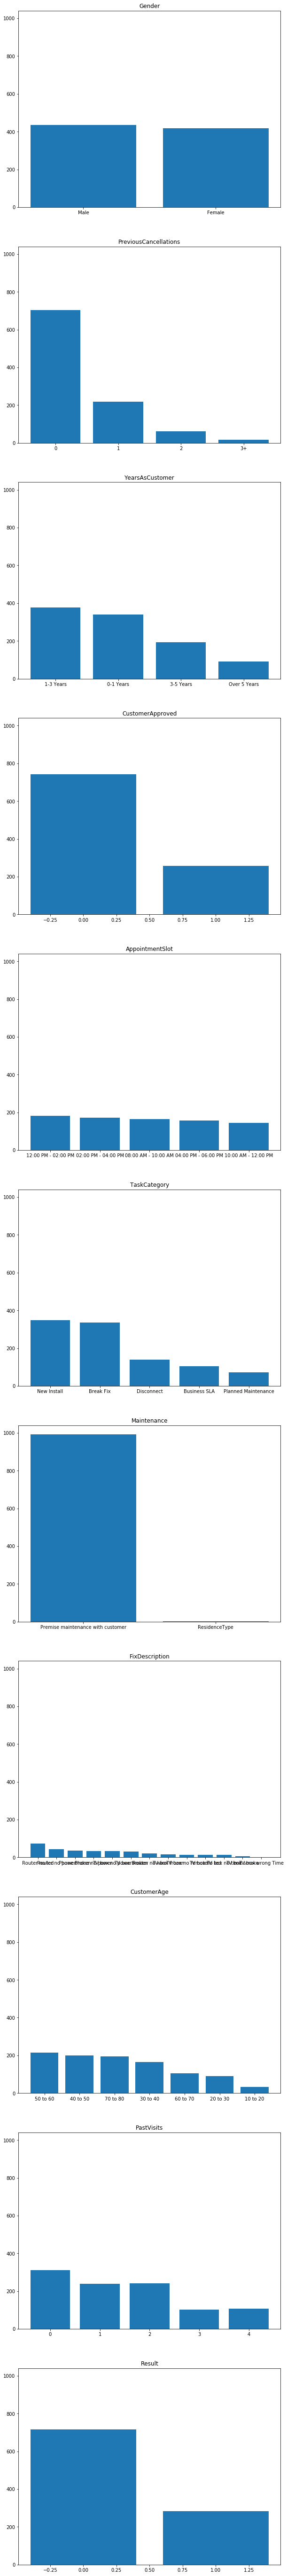

In [5]:
# Histograms of features

columns_names = raw_data.columns
cols_to_hist = columns_names\
    .drop(['OpenDate', 'AppointmentDate', 'FirstName', 'LastName', 'EngineerKey'])
fig, ax = plt.subplots(len(cols_to_hist), 1, figsize=(10, 100), sharey=True)
for c, col in enumerate(cols_to_hist):
    d = dict(raw_data[col].value_counts())
    ax[c].set_title(col)
    ax[c].bar(d.keys(), d.values())

### Data preparation desicions:

1. FixDescription will be droped: has 60 % Nans
    
2. Maintenance will be droped: has all same value (except 1)

3. First and last name are not interesing for prediction

4. I will not use open and appointement dates. Instead I'll calculate the gap between them and use it

5. In Gender and AppointmentSlot nulls would be replaced in 'unknown' as new category

** Droped columns can be restored using the raw_data

In [6]:
# Calculate number of days between two dates

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%m/%d/%y")
    d2 = datetime.strptime(d2, "%m/%d/%y")
    return (d2 - d1).days


In [7]:

raw_data['DateGap'] = raw_data \
    .apply(lambda row: days_between(row['OpenDate'], row['AppointmentDate']), axis=1)

data = raw_data \
    .drop(['FixDescription', 'Maintenance', 'OpenDate', 'AppointmentDate', 'FirstName', 'LastName'], axis=1) \
    .fillna('unknown')


In [8]:
# Categorical features to dummies (Including EngineerKey)

categorical_features = data.columns.drop(['PastVisits', 'DateGap', 'Result'])
dummies = pd.DataFrame(data=pd.get_dummies(data[categorical_features].astype(str)))
data = data.drop(categorical_features, axis=1)
data = data.join(dummies)


## Evaluate and compare models:

For comparison I will use F-measure, using beta=2 (i.e. recall is 2 times more important than precision) because I think it is not so bad having a little more false positive in order to achive better predictions for jobs will not be completed
 
### Metric to use: F_beta = (1+b^2^) * (precision * recall)/((b^2^*precision)+recall)

In [9]:
# This function is doing k-fold cross-validation

def kf_cv(df, model, splits = 5):
    acc=0
    recall=0
    precision=0
    kf = KFold(splits)
    for train_i, valid_i in kf.split(df):
        X_train = np.array(df.drop('Result', axis=1))[train_i, :]
        X_valid = np.array(df.drop('Result', axis=1))[valid_i,:]
        y_train = np.array(df['Result'])[train_i]
        y_valid = np.array(df['Result'])[valid_i]
        model.fit(X_train, y_train)
        a,r,p = model.evaluate(X_valid, y_valid)
        acc += a
        recall += r
        precision += p 
    acc = acc/splits
    recall = recall/splits
    return acc, recall, precision

In [10]:
def F_beta (precision, recall, b=2):
    return (1+b**2)*(precision*recall)/((b**2)*precision+recall)

In [11]:
log_model = LogisticModel()
acc, recall, precision = kf_cv(data, log_model)
f = F_beta(precision, recall)
print('Logistic regression model')
print('Accuracy: %f' % acc)
print('F_beta: %f' % f)


Logistic regression model
Accuracy: 0.825000
F_beta: 0.747810


In [13]:
rf_model = RandomForest()
acc, recall, precision = kf_cv(data, rf_model)
f = F_beta(precision, recall)
print('Random forest model')
print('Accuracy: %f' % acc)
print('F_beta: %f' % f)

Random forest model
Accuracy: 0.835000
F_beta: 0.709945


In [16]:
boost_model = AdaBoost()
acc, recall, precision = kf_cv(data, boost_model)
f = F_beta(precision, recall)
print('AdaBoost model')
print('Accuracy: %f' % acc)
print('F_beta: %f' % f)

AdaBoost model
Accuracy: 0.860000
F_beta: 0.875295


In [15]:
nn_model = MLP()
acc, recall, precision = kf_cv(data, nn_model)
f = F_beta(precision, recall)
print('MLP model')
print('Accuracy: %f' % acc)
print('F_beta: %f' % f)


MLP model
Accuracy: 0.828000
F_beta: 0.767206


## Conclusions:
The AdaBoost model has the best F_beta value which is the metric to choose a model.
It also has the best accuracy.

If I had to choose based on this work, AdaBoost is the winner!

## Future development:
1. More data!! (if possible...)
2. More data exploration:

	a. Bi-variate anaysis

	b. Correlations with the 'Result'

3. Tuning hyper-parameters:
	
	a. For random forest and AdaBoost, mostly n_estimators
	
	b. For MLP trying different layers amount and sizes

4. Trying more models. (Focus on models using boosting because it is the best so far)
